In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import pickle
import os
import plotnine
import warnings
from plotnine import *
import pandas as pd
from pandas import Series
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error
from kerasAC.generators import *
import pybedtools

Using TensorFlow backend.


## Select GPU

In [3]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
!env | grep "CUDA"

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
CUDA_VISIBLE_DEVICES=1
CUDA_HOME=/usr/local/cuda-10.0


## Get Model and Peak File Addresses

In [4]:
idr_peaks=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/idr.optimal.narrowPeaks.txt','r').read().strip().split('\n')
samples=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/samples.txt','r').read().strip().split('\n')
model_dict={}
idr_dict={}
for sample in samples:
    print(sample)
    model_dict[sample]='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/mean/'+sample+'.model.'
    for idr_peaks_file in idr_peaks:
        if idr_peaks_file.__contains__(sample):
            idr_dict[sample]=idr_peaks_file

AD_ADAD_CAUD
AD_ADAD_HIPP
AD_ADAD_PARL
AD_ADAD_SMTG
AD_CTRH_CAUD
AD_CTRH_HIPP
AD_CTRH_PARL
AD_CTRH_SMTG
AD_CTRL_CAUD
AD_CTRL_HIPP
AD_CTRL_PARL
AD_CTRL_SMTG
AD_LOAD_CAUD
AD_LOAD_HIPP
AD_LOAD_PARL
AD_LOAD_SMTG
PD_CTRL_CAUD
PD_CTRL_HIPP
PD_CTRL_MDFG
PD_CTRL_MDTG
PD_CTRL_PTMN
PD_CTRL_SUNI
PD_GBA1_CAUD
PD_GBA1_HIPP
PD_GBA1_MDFG
PD_GBA1_MDTG
PD_GBA1_PTMN
PD_GBA1_SUNI
PD_LOPD_CAUD
PD_LOPD_HIPP
PD_LOPD_MDFG
PD_LOPD_MDTG
PD_LOPD_PTMN
PD_LOPD_SUNI
PD_LRRK_CAUD
PD_LRRK_HIPP
PD_LRRK_MDFG
PD_LRRK_MDTG
PD_LRRK_PTMN
PD_LRRK_SUNI


## Function to separate alternate alleles into individual rows

In [5]:
def format_snps(old_file, alt_col, new_file):
    old = pd.read_csv(old_file, sep='\t')
    s = old[alt_col].str.split(',').apply(Series, 1).stack()
    s.index = s.index.droplevel(-1)
    s.name = alt_col
    x = old.columns
    del old[alt_col]
    new = old.join(s)
    new = new[x]
    new.to_csv(new_file, sep='\t', index=False)

## Select Task

In [6]:
task='AD_CTRL_SMTG'
snp_prefix="/mnt/lab_data2/annashch/alzheimers_parkinsons/dl_interpret/"
n_folds=10 
num_tasks=1 
all_snps_basename="chr17-only_dbsnp151_common_MAPT_HaplotypeRegion.txt"
ref_fasta="/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
model_prefix=model_dict[task]
idr_peaks=idr_dict[task]

## Get Predictions

In [7]:
for fold in [7]: 
    print(fold)
    #load the model
    custom_objects={"recall":recall,
                    "sensitivity":recall,
                    "specificity":specificity,
                    "fpr":fpr,
                    "fnr":fnr,
                    "precision":precision,
                    "f1":f1,
                    "ambig_binary_crossentropy":ambig_binary_crossentropy,
                    "ambig_mean_squared_error":ambig_mean_squared_error}
    model=load_model(model_prefix+str(fold),custom_objects=custom_objects)
    print("loaded model")
    #get reference allele predictions 
    snp_file='/'.join([snp_prefix,all_snps_basename])+'.'+str(fold)
    format_snps(snp_file, 'ALT', snp_file+'.corrected')
    new_snp_file = snp_file+'.corrected'
    snp_ref_generator=SNPGenerator(data_path=new_snp_file,
                                   ref_fasta=ref_fasta,
                                   allele_col="REF")
    snp_ref_predictions=model.predict_generator(snp_ref_generator,
                                                max_queue_size=5000, 
                                                workers=40, 
                                                use_multiprocessing=True,
                                                verbose=1)
    print("got snp ref predictions")
    #get alternate allele predictions 
    snp_alt_generator=SNPGenerator(new_snp_file,
                                   ref_fasta=ref_fasta,
                                   allele_col="ALT")
    snp_alt_predictions=model.predict_generator(snp_alt_generator,
                                                max_queue_size=5000, 
                                                workers=40, 
                                                use_multiprocessing=True, verbose=1)
    print("got snp alt predictions")

W0723 02:34:24.561261 139709664847680 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 02:34:24.578008 139709664847680 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



7


W0723 02:34:24.604266 139709664847680 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 02:34:24.605575 139709664847680 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 02:34:24.606633 139709664847680 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0723 02:34:26.501605 139709664847680 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: 

loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(14506, 6)
114/114 [==============================] - 7s 57ms/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(14506, 6)
114/114 [==============================] - 6s 53ms/step
got snp alt predictions


## Save SNP Predictions

In [8]:
snp_ref_generator.data['ref_pred']=snp_ref_predictions
snp_ref_generator.data['alt_pred']=snp_alt_predictions
snp_ref_generator.data.to_csv(task+'.MAPT.SNP_predictions.txt',sep='\t')

## Load SNP Predictions

In [9]:
snp_predictions=pd.read_csv(task+'.MAPT.SNP_predictions.txt',header=0,sep='\t')
display(snp_predictions.head())
display(snp_predictions.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred
0,chr17,45465841,45465842,rs62065396,T,C,.,.,RS=62065396;RSPOS=45465841;dbSNPBuildID=129;SS...,0.003366,0.003837
1,chr17,45466206,45466207,rs146474745,A,G,.,.,RS=146474745;RSPOS=45466206;dbSNPBuildID=134;S...,0.034998,0.029319
2,chr17,45466223,45466224,rs528188735,CT,C,.,.,RS=528188735;RSPOS=45466224;dbSNPBuildID=142;S...,0.063934,0.063934
3,chr17,45466223,45466224,rs367902572,CT,C,.,.,RS=367902572;RSPOS=45466225;dbSNPBuildID=138;S...,0.063934,0.063934
4,chr17,45466299,45466300,rs8077198,T,C,.,.,RS=8077198;RSPOS=45466299;dbSNPBuildID=116;SSR...,0.063657,0.066106


(14506, 11)

## Calculate Number of SNPs in Peaks

In [10]:
old_snp_bed = pybedtools.BedTool(snp_file)
idr_bed = pybedtools.BedTool(idr_peaks)
pos_snps_old = old_snp_bed.intersect(idr_bed, u=True)
pos_snps_df_old = pybedtools.BedTool.to_dataframe(pos_snps_old)
pos_snps_df_old.columns = ['CHR', 'START', 'END', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']
display(pos_snps_df_old.head())
display(pos_snps_df_old.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO
0,chr17,45487744,45487745,rs140167395,G,"C,T",.,.,RS=140167395;RSPOS=45487744;dbSNPBuildID=134;S...
1,chr17,45488057,45488058,rs145791681,G,A,.,.,RS=145791681;RSPOS=45488057;dbSNPBuildID=134;S...
2,chr17,45488085,45488086,rs533387603,G,A,.,.,RS=533387603;RSPOS=45488085;dbSNPBuildID=142;S...
3,chr17,45488233,45488234,rs62065444,T,C,.,.,RS=62065444;RSPOS=45488233;dbSNPBuildID=129;SS...
4,chr17,45490318,45490319,rs540797580,G,"A,C",.,.,RS=540797580;RSPOS=45490318;dbSNPBuildID=142;S...


(715, 9)

## Subset to SNPs in Peaks

In [11]:
snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
idr_bed = pybedtools.BedTool(idr_peaks)
pos_snps_bed = snp_bed.intersect(idr_bed, u=True)
pos_snps = pybedtools.BedTool.to_dataframe(pos_snps_bed)
pos_snps.columns = snp_predictions.columns
display(pos_snps.head())
display(pos_snps.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred
0,chr17,45487744,45487745,rs140167395,G,C,.,.,RS=140167395;RSPOS=45487744;dbSNPBuildID=134;S...,0.127284,0.137177
1,chr17,45487744,45487745,rs140167395,G,T,.,.,RS=140167395;RSPOS=45487744;dbSNPBuildID=134;S...,0.127284,0.133661
2,chr17,45488057,45488058,rs145791681,G,A,.,.,RS=145791681;RSPOS=45488057;dbSNPBuildID=134;S...,0.245039,0.230351
3,chr17,45488085,45488086,rs533387603,G,A,.,.,RS=533387603;RSPOS=45488085;dbSNPBuildID=142;S...,0.370145,0.363248
4,chr17,45488233,45488234,rs62065444,T,C,.,.,RS=62065444;RSPOS=45488233;dbSNPBuildID=129;SS...,1.230386,1.218777


(820, 11)

## Plot Reference vs. Alternate Allele Predictions

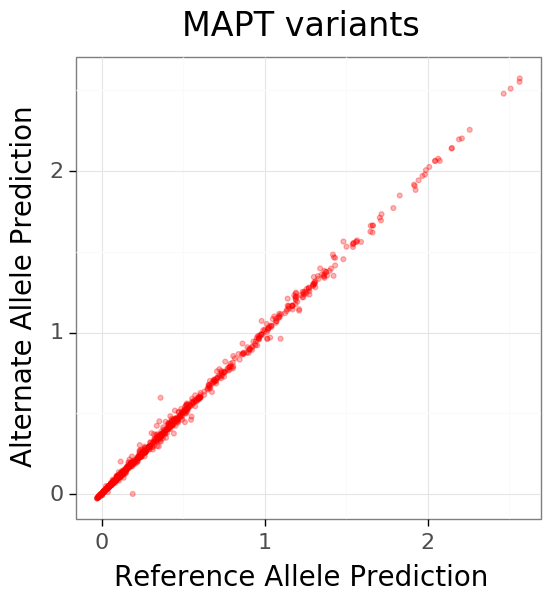

<ggplot: (8731375231510)>

In [12]:
plotnine.options.figure_size = (6,6)
(ggplot(pos_snps,
        aes(x="ref_pred",y="alt_pred",label='ID'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Prediction")+
ylab("Alternate Allele Prediction")+
ggtitle("MAPT variants"))

## Calculate Difference between Reference and Alternate Prediction

In [13]:
pos_snps['delta']=pos_snps['alt_pred']-pos_snps['ref_pred']
pos_snp_predictions_sorted=pos_snps.sort_values(by=['delta'])

## Get Alternate SNPs with most negative effect

In [14]:
pos_snp_predictions_sorted.head(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
765,chr17,46286843,46286844,rs2732614,C,T,.,.,RS=2732614;RSPOS=46286843;RV;dbSNPBuildID=100;...,0.191300,0.000437,-0.190862
760,chr17,46267724,46267725,rs2668719,C,A,.,.,RS=2668719;RSPOS=46267724;dbSNPBuildID=100;SSR...,1.097538,0.961699,-0.135839
813,chr17,46779478,46779479,rs112614367,C,T,.,.,RS=112614367;RSPOS=46779478;dbSNPBuildID=132;S...,0.548733,0.459699,-0.089034
755,chr17,46267622,46267623,rs2732650,C,G,.,.,RS=2732650;RSPOS=46267622;dbSNPBuildID=100;SSR...,1.211165,1.135518,-0.075647
66,chr17,45586315,45586316,rs536494125,ACCCGCACCGCGCTGCAG,A,.,.,RS=536494125;RSPOS=45586316;dbSNPBuildID=142;S...,0.551865,0.479214,-0.072651
720,chr17,46260550,46260551,rs535130726,C,T,.,.,RS=535130726;RSPOS=46260550;dbSNPBuildID=142;S...,1.422222,1.351582,-0.070641
99,chr17,45677948,45677949,rs114765486,G,A,.,.,RS=114765486;RSPOS=45677948;dbSNPBuildID=132;S...,0.443448,0.374606,-0.068841
756,chr17,46267622,46267623,rs2732650,C,T,.,.,RS=2732650;RSPOS=46267622;dbSNPBuildID=100;SSR...,1.211165,1.144851,-0.066314
210,chr17,45748125,45748126,rs8064404,G,A,.,.,RS=8064404;RSPOS=45748125;dbSNPBuildID=116;SSR...,0.511244,0.445212,-0.066031
578,chr17,46038946,46038947,rs62062136,T,C,.,.,RS=62062136;RSPOS=46038946;dbSNPBuildID=129;SS...,1.033643,0.968931,-0.064713


## Get Alternate SNPs with most positive effect

In [15]:
pos_snp_predictions_sorted.tail(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
245,chr17,45784236,45784237,rs556987000,G,C,.,.,RS=556987000;RSPOS=45784236;dbSNPBuildID=142;S...,0.864156,0.931883,0.067727
709,chr17,46260063,46260064,rs36061720,G,C,.,.,RS=36061720;RSPOS=46260063;dbSNPBuildID=126;SS...,0.234128,0.302720,0.068592
252,chr17,45784874,45784875,rs550550908,G,C,.,.,RS=550550908;RSPOS=45784874;dbSNPBuildID=142;S...,1.140717,1.210248,0.069531
115,chr17,45703521,45703522,rs116897693,G,A,.,.,RS=116897693;RSPOS=45703521;dbSNPBuildID=132;S...,0.306876,0.377326,0.070449
47,chr17,45585365,45585366,rs112069536,G,C,.,.,RS=112069536;RSPOS=45585365;dbSNPBuildID=132;S...,1.482702,1.563795,0.081093
607,chr17,46044551,46044552,rs77768866,C,T,.,.,RS=77768866;RSPOS=46044551;dbSNPBuildID=137;SS...,0.338954,0.422463,0.083509
546,chr17,46002270,46002271,rs116485294,G,C,.,.,RS=116485294;RSPOS=46002270;dbSNPBuildID=132;S...,0.117281,0.200871,0.083590
433,chr17,45896222,45896223,rs571814003,G,A,.,.,RS=571814003;RSPOS=45896222;dbSNPBuildID=142;S...,0.981483,1.072011,0.090528
382,chr17,45870151,45870152,rs114015305,A,G,.,.,RS=114015305;RSPOS=45870151;dbSNPBuildID=132;S...,0.354231,0.450737,0.096507
134,chr17,45705590,45705591,rs149367053,CTG,C,.,.,RS=149367053;RSPOS=45705591;dbSNPBuildID=134;S...,0.362084,0.596194,0.234110


## Subset to SNPs NOT in Peaks

In [16]:
snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
idr_bed = pybedtools.BedTool(idr_peaks)
neg_snps_bed = snp_bed.intersect(idr_bed, v=True)
neg_snps = pybedtools.BedTool.to_dataframe(neg_snps_bed)
neg_snps.columns = snp_predictions.columns
display(neg_snps.head())
display(neg_snps.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred
0,chr17,45465841,45465842,rs62065396,T,C,.,.,RS=62065396;RSPOS=45465841;dbSNPBuildID=129;SS...,0.003366,0.003837
1,chr17,45466206,45466207,rs146474745,A,G,.,.,RS=146474745;RSPOS=45466206;dbSNPBuildID=134;S...,0.034998,0.029319
2,chr17,45466223,45466224,rs528188735,CT,C,.,.,RS=528188735;RSPOS=45466224;dbSNPBuildID=142;S...,0.063934,0.063934
3,chr17,45466223,45466224,rs367902572,CT,C,.,.,RS=367902572;RSPOS=45466225;dbSNPBuildID=138;S...,0.063934,0.063934
4,chr17,45466299,45466300,rs8077198,T,C,.,.,RS=8077198;RSPOS=45466299;dbSNPBuildID=116;SSR...,0.063657,0.066106


(13686, 11)

## Plot Reference vs. Alternate Allele Predictions

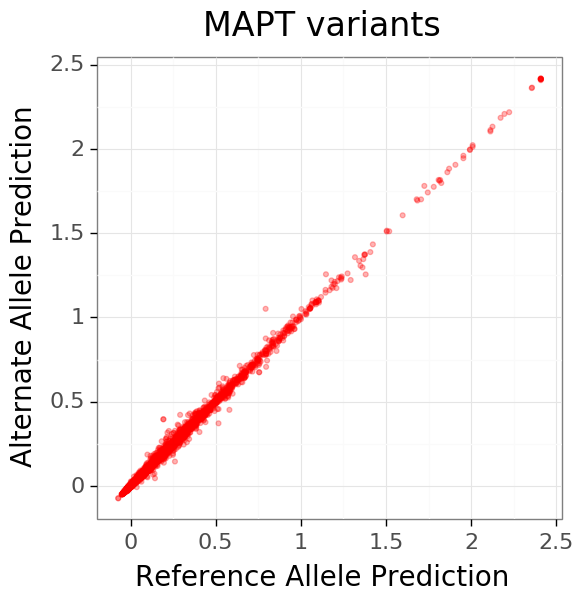

<ggplot: (8731375371556)>

In [17]:
plotnine.options.figure_size = (6,6)
(ggplot(neg_snps,
        aes(x="ref_pred",y="alt_pred",label='ID'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Prediction")+
ylab("Alternate Allele Prediction")+
ggtitle("MAPT variants"))

## Calculate Difference between Reference and Alternate Prediction

In [18]:
neg_snps['delta']=neg_snps['alt_pred']-neg_snps['ref_pred']
neg_snp_predictions_sorted=neg_snps.sort_values(by=['delta'])

## Get Alternate SNPs with most negative effect

In [19]:
neg_snp_predictions_sorted.head(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
460,chr17,45501558,45501559,rs149575984,G,A,.,.,RS=149575984;RSPOS=45501558;dbSNPBuildID=134;S...,0.516252,0.371673,-0.144579
4237,chr17,45801639,45801640,rs142141590,C,CCAGTTT,.,.,RS=142141590;RSPOS=45801639;dbSNPBuildID=134;S...,0.580254,0.451609,-0.128645
13453,chr17,46765305,46765306,rs541254264,CACTCG,C,.,.,RS=541254264;RSPOS=46765306;dbSNPBuildID=142;S...,1.380959,1.255251,-0.125708
655,chr17,45518782,45518783,rs544718682,G,A,.,.,RS=544718682;RSPOS=45518782;dbSNPBuildID=142;S...,0.260332,0.145055,-0.115277
12867,chr17,46649421,46649422,rs547140629,C,T,.,.,RS=547140629;RSPOS=46649421;dbSNPBuildID=142;S...,0.142956,0.045724,-0.097232
1715,chr17,45621266,45621267,rs575921901,G,A,.,.,RS=575921901;RSPOS=45621266;dbSNPBuildID=142;S...,0.795856,0.706871,-0.088985
458,chr17,45501545,45501546,rs190583615,C,G,.,.,RS=190583615;RSPOS=45501545;dbSNPBuildID=135;S...,0.404405,0.320051,-0.084355
5544,chr17,45874233,45874234,rs67344622,CAGAT,C,.,.,RS=67344622;RSPOS=45874234;RV;dbSNPBuildID=137...,0.755194,0.674737,-0.080457
5545,chr17,45874233,45874234,rs67687156,CAGAT,C,.,.,RS=67687156;RSPOS=45874236;dbSNPBuildID=131;SS...,0.755194,0.674737,-0.080457
3083,chr17,45722444,45722445,rs76667867,G,A,.,.,RS=76667867;RSPOS=45722444;dbSNPBuildID=132;SS...,0.330588,0.259650,-0.070939


## Get Alternate SNPs with most positive effect

In [20]:
neg_snp_predictions_sorted.tail(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
13276,chr17,46743095,46743096,rs555384034,G,C,.,.,RS=555384034;RSPOS=46743095;dbSNPBuildID=142;S...,0.276338,0.364011,0.087673
12770,chr17,46586417,46586418,rs545764163,C,T,.,.,RS=545764163;RSPOS=46586417;dbSNPBuildID=142;S...,0.518798,0.607452,0.088654
666,chr17,45520224,45520225,rs115881608,A,T,.,.,RS=115881608;RSPOS=45520224;dbSNPBuildID=132;S...,0.544785,0.639558,0.094772
2565,chr17,45688515,45688516,rs6503443,T,C,.,.,RS=6503443;RSPOS=45688515;dbSNPBuildID=116;SSR...,0.216051,0.315920,0.099869
4587,chr17,45823809,45823810,rs182044177,G,C,.,.,RS=182044177;RSPOS=45823809;dbSNPBuildID=135;S...,0.224695,0.326448,0.101753
5893,chr17,45897523,45897524,rs62056784,C,G,.,.,RS=62056784;RSPOS=45897523;dbSNPBuildID=129;SS...,1.147435,1.256022,0.108587
5364,chr17,45864380,45864381,rs547985351,TGA,T,.,.,RS=547985351;RSPOS=45864381;dbSNPBuildID=142;S...,0.290674,0.421998,0.131324
8648,chr17,46078766,46078767,rs75081565,T,TTTA,.,.,RS=75081565;RSPOS=46078768;dbSNPBuildID=131;SS...,0.192377,0.395669,0.203293
8647,chr17,46078766,46078767,rs111750615,T,TTTA,.,.,RS=111750615;RSPOS=46078766;dbSNPBuildID=132;S...,0.192377,0.395669,0.203293
13462,chr17,46765939,46765940,rs546015780,G,A,.,.,RS=546015780;RSPOS=46765939;dbSNPBuildID=142;S...,0.793057,1.051116,0.258059
